#### model1_andrewpt_blend_S8_4269_time_290955_public_8_4269_private_8_42454_local_7_850758_lgb

In [1]:
#import utils
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys,inspect,pickle,json,time,datetime,re
import random as rn
import lightgbm as lgb
%matplotlib inline
#DATA_DIR = "../input/activity-atactic/"
DATA_DIR = "../input/sibur-csv/"#"../baseline/"


train_data = pd.read_csv(DATA_DIR + "activity_train.csv.zip", parse_dates=["date"], index_col="date", compression="zip")
test_data = pd.read_csv(DATA_DIR + "activity_test.csv.zip", parse_dates=["date"], index_col="date", compression="zip")
activity_test_target = pd.read_csv(DATA_DIR + "activity_test_timestamps.csv", index_col="date", parse_dates=["date"])
print('train',train_data.shape, 'test',test_data.shape, 'activity_test_target',activity_test_target.shape)#, 'atactic_test_target',atactic_test_target.shape)



train (463058, 60) test (103651, 56) activity_test_target (85891, 0)


In [2]:
# prepare data for feature engineering
data = pd.concat([train_data[test_data.columns], test_data]) ;print('data',data.shape) # use all columns except 4 targets
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy() ;print('train_targets',train_targets.shape)
#series = train_targets[['activity']].notnull().all(axis=1) ;print(len(series[series==True]), 'rows without any null in whole row') # 300759 

data (566709, 56)
train_targets (463058, 4)


In [3]:
# generate 825 new cols from joineddata
data.drop("f28", axis=1, inplace=True)
#ACOLS = ["atactic_1", "atactic_2", "atactic_3"]
#not_null_atactic = train_targets.loc[train_targets[ACOLS].notnull().all(axis=1), ACOLS] ;print(not_null_atactic.shape)
PERIODS = ["1H", "3H", "6H"]
AGGREGATES = ["mean", "median", "std", "max", "min"]
#PERIODS = ["3H"]
#AGGREGATES = ["mean"]
all_features = []
for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        print(period,agg,end=',')
        rolling_features = data.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features)
all_features = pd.concat(all_features, axis=1) 
print('all_features',all_features.shape) #825/5/3 = 55 #15 new cols for each of 55 features 


1H mean,1H median,1H std,1H max,1H min,3H mean,3H median,3H std,3H max,3H min,6H mean,6H median,6H std,6H max,6H min,
all_features (566709, 825)


In [4]:
# join all new features
full_data = data.join(all_features) ;print('full_data',full_data.shape)  # (566709, 880)
activity_train_with_nulls = train_targets[["activity"]].join(full_data.shift(6, freq="H")) ;print('activity_train_with_nulls',activity_train_with_nulls.shape) # add 6 hours empty rows to start, delete last 6 hours rows
#series = activity_train_with_nulls.notnull().all(axis=1) ;print(len(series[series==True]), 'rows without any null in whole row') # 300759 
activity_train = activity_train_with_nulls[activity_train_with_nulls.notnull().all(axis=1)] ;print('activity_train',activity_train.shape)
#activity_test = full_data[full_data.index >= test_data.index[0]] ;print('activity_test',activity_test.shape)
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill() ; print('test_activity_data',test_activity_data.shape) # test_activity_data (85891, 880)

full_data (566709, 880)
activity_train_with_nulls (463058, 881)
activity_train (300737, 881)
test_activity_data (85891, 880)


In [5]:
# rename data
train_data = activity_train
#test_data_useless = activity_test
test_data = test_activity_data
extra_data1 = activity_test_target
print('train_data',train_data.shape, 'test_data',test_data.shape, 'extra_data1',extra_data1.shape)


train_data (300737, 881) test_data (85891, 880) extra_data1 (85891, 0)


In [6]:
# config for models tuning
config_lgb = """{
    "models":"lgb",
    "datasize":"max",
    "data":"v02_add55x5x3roll",
    "rs":2734,
    "lgb": {
        "_comment":"lambda_l2,lambda_l1,min_gain_to_split 30 5 8",
        "name":"lgb",
        "tune":"",
        "rs":2734,
        "metric":"mape", 
        "num_threads": -1, 
        "objective": "regression", 
        "verbosity": 1,
        "rounds":150,
        "verbose_eval":100,
        "early_stopping_rounds":20000,
        "lambda_l2":30,
        "lambda_l1":5,
        "min_gain_to_split":8,
        "num_leaves":31
    }
}"""
conf = json.loads(config_lgb.replace("'", "\""))

In [7]:
# lgb wrapper
class TrainLGB():
    model = None
    conf = None
    history_callback = None
    def __init__(self, conf):
        self.conf = conf
        #print('lgb init done')
        return
    def compile(self, x_train_shape):
        #print('lgb define done')
        return
    def fit(self, x_train, y_train, x_val, y_val):
        lgb_train = lgb.Dataset(x_train, label=y_train.reshape(-1))
        lgb_val = lgb.Dataset(x_val, label=y_val.reshape(-1))
        evals_result = {}
        c=self.conf
        #params = {'metric':'mape', 'num_threads': -1, 'objective': 'regression', 'verbosity': 1} # rmse
        params = {
            'metric':c['metric'], 
            'num_threads':c['num_threads'], 
            'objective': c['objective'], 
            'verbosity': c['verbosity'], 
            'is_training_metric': True,
            'lambda_l2':c['lambda_l2'],
            'lambda_l1':c['lambda_l1'],
            'min_gain_to_split':c['min_gain_to_split'],
            'num_leaves':c['num_leaves'],
        } # rmse
        rounds = c['rounds']
        # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html
        self.model = lgb.train(
            params = params, 
            #lgb_train, 
            train_set = lgb_train, 
            num_boost_round = rounds, 
            valid_sets = [lgb_train,lgb_val], 
            verbose_eval=c['verbose_eval'], 
            early_stopping_rounds=c['early_stopping_rounds'], 
            callbacks=[lgb.record_evaluation(evals_result)] #same -> evals_result=evals_result,
            #callbacks=[lgb.print_evaluation(period=1, show_stdv=True)] #same -> evals_result=evals_result,
        )
        steps = self.model.best_iteration #print(f"Best: {steps}") #print('lgb fit done')
        self.history_callback = evals_result
        return
    def predict(self, x):
        #print('lgb predict done')
        return self.model.predict(x)
    def get_costs(self):
        oy_train_list = self.history_callback['training']['mape']
        oy_train_list = list(np.array(oy_train_list, dtype=np.float32))
        oy_val_list = self.history_callback['valid_1']['mape']
        oy_val_list = list(np.array(oy_val_list, dtype=np.float32))
        #ox_list = [x for x in range(1,self.conf['rounds']+1)] # early stopping can cause error
        ox_list = [x for x in range(1,len(oy_train_list)+1)]
        title = self.conf['name'] + '_'
        for t in self.conf['tune'].split(','): 
            if t!='': title += t+'_'+str(self.conf[t])+'_'
        return {'ox_list':ox_list, 'oy_train_list':oy_train_list, 'oy_val_list':oy_val_list, 'title':title}


In [8]:
TARGET = 'activity'
rn.seed(conf['rs'])
np.random.seed(conf['rs'])

# split rows
train = train_data
val   = train_data
test  = test_data

# split cols to numpy and norm
def split_cols_np(train, val, test, TARGET):
    x_train = train.drop(TARGET, axis=1, inplace=False).values # faster if target first col: train.iloc[:, 1:].values
    x_val   = val.drop(TARGET, axis=1, inplace=False).values   # val.iloc[:, 1:].values
    x_test  = test.values
    y_train = train[[TARGET]].values
    y_val   = val[[TARGET]].values
    return x_train, x_val, x_test, y_train, y_val
x_train, x_val, x_test, y_train, y_val = split_cols_np(train, val, test, TARGET) ;print('x_train',x_train.shape, 'y_train',y_train.shape, 'x_val',x_val.shape, 'y_val',y_val.shape, 'x_test',x_test.shape)

# normalize
def normalize_by_train(x_train, x_val, x_test, y_train, y_val, train, TARGET):
    #center, scale = train.iloc[:, 1:].mean().values, train.iloc[:, 1:].std().values
    center_x, scale_x = train.drop(TARGET, axis=1, inplace=False).mean().values, train.drop(TARGET, axis=1, inplace=False).std().values
    center_y, scale_y = train[TARGET].mean(), train[TARGET].std()
    x_train_n = (x_train - center_x)/scale_x
    x_val_n   = (x_val   - center_x)/scale_x
    x_test_n  = (x_test  - center_x)/scale_x
    y_train_n = (y_train - center_y)/scale_y
    y_val_n   = (y_val   - center_y)/scale_y
    #print('x_train_n',x_train_n.shape, 'y_train_n',y_train_n.shape, 'x_val_n',x_val_n.shape, 'y_val_n', y_val_n.shape)
    return x_train_n, x_val_n, x_test_n, y_train_n, y_val_n
x_train_n, x_val_n, x_test_n, y_train_n, y_val_n = normalize_by_train(x_train, x_val, x_test, y_train, y_val, train, TARGET) #;print('x_train_n',x_train_n.shape, 'y_train_n',y_train_n.shape, 'x_val_n',x_val_n.shape, 'y_val_n', y_val_n.shape)

def denormalize_by_train(y_train_pred_n, y_val_pred_n, y_test_pred_n, train, TARGET):
    y_train_pred = y_train_pred_n * train[TARGET].std() + train[TARGET].mean()
    y_val_pred   = y_val_pred_n   * train[TARGET].std() + train[TARGET].mean() # cause center/scale made from train only
    y_test_pred  = y_test_pred_n  * train[TARGET].std() + train[TARGET].mean() # cause center/scale made from train only
    return y_train_pred, y_val_pred, y_test_pred

def evaluate(y_train_pred_n, y_val_pred_n, y_test_pred_n, conf_i, submit=False):
    # denormalize
    y_train_pred, y_val_pred, y_test_pred = denormalize_by_train(y_train_pred_n, y_val_pred_n, y_test_pred_n, train, TARGET)

    # convert to pandas
    y_train_pred_p = pd.Series(y_train_pred.flatten(), index=train.index, name=TARGET+"_pred").sort_index()
    y_val_pred_p   = pd.Series(y_val_pred.flatten(),   index=val.index,   name=TARGET+"_pred").sort_index()
    y_test_pred_p  = pd.DataFrame(y_test_pred, columns=[TARGET], index=extra_data1.index) # activity_test_target

    # evaluate
    def mape(y_true, y_pred): return 100 * np.mean(np.abs((y_pred-y_true)/y_true))
    conf_i['score_train']= mape(train[TARGET].values, y_train_pred_p.values)
    conf_i['score_val']  = mape(val[TARGET].values,   y_val_pred_p.values)

    # submit
    curr_time = re.sub(r'^(.*)-(.*)-(.*) (.*):(.*):(.*)\.(.*)$',r'y\1_\2m_\3d_\4h_\5min_\6s_\7_',str(datetime.datetime.now()))
    #if submit: y_test_pred_p.loc[test.index].to_csv(os.path.join('output',curr_time+mtype+'_sub.csv'))
    #if submit: y_test_pred_p.loc[test.index].to_csv(curr_time+mtype+'_sub.csv')
    if submit: y_test_pred_p.loc[test.index].to_csv('submit_model1.csv')

    # add log to log_model.csv file
    log_file = 'log\\log_model1_'+mtype+'.csv'
    log_df = pd.DataFrame([conf_i], index=[curr_time])
    if log_file in os.listdir(): log_df = pd.read_csv(log_file, index_col=0).append(log_df)   
    log_df.to_csv(log_file)

    #if log_file in os.listdir('output'): log_df = pd.read_csv(os.path.join('output', log_file), index_col=0).append(log_df)   
    #log_df.to_csv(os.path.join('output', log_file))
    # add log to separate file
    #pd.DataFrame([conf_i], index=[curr_time]).to_csv(os.path.join('output',curr_time+mtype+'_log.csv'))
    return


x_train (300737, 880) y_train (300737, 1) x_val (300737, 880) y_val (300737, 1) x_test (85891, 880)


In [9]:
def split_model_config(conf_mtype): # in: model params with lists, out: list of params-combination
    if conf_mtype['tune']=='': return [conf_mtype]
    import itertools; model_configs = []; list_of_lists = []
    def tunelists_to_floats(conf_mtype, comb):
        conf_i = conf_mtype.copy()
        for i,t in enumerate(conf_mtype['tune'].split(',')): conf_i[t] = comb[i]
        return conf_i
    # 1 build list of lists
    for t in conf_mtype['tune'].split(','): list_of_lists.append(conf_mtype[t])
    # 2 get all combinations of a list of lists
    combs = list(itertools.product(*list_of_lists)) # [(2734, 10), (2734, 20), (2734, 30), (1, 10), (1, 20), (1, 30), (2, 10), (2, 20), (2, 30)]
    # 3 fill separate model_config from each combination 
    for comb in combs:model_configs.append(tunelists_to_floats(conf_mtype, comb))
    return model_configs
    #print(split_model_config(conf['lgb']))

for mtype in conf['models'].split(','):
    for conf_i in split_model_config(conf[mtype]):
        if mtype=='lgb':
            #from train_lgb import TrainLGB
            model = TrainLGB(conf_i)
        model.compile(x_train.shape)
        model.fit(x_train_n, y_train_n, x_val_n, y_val_n)
        y_train_pred_n = model.predict(x_train_n) 
        y_val_pred_n   = model.predict(x_val_n) 
        y_test_pred_n  = model.predict(x_test_n) 
        conf_i['history'] = model.get_costs() #model.history_callback
        conf_i['datasize'] = conf['datasize']
        conf_i['data'] = conf['data']
        conf_i['rs_global'] = conf['rs']
        evaluate(y_train_pred_n, y_val_pred_n, y_test_pred_n, conf_i, submit=True)
        #plot_costs(*model.get_costs())


Training until validation scores don't improve for 20000 rounds
[100]	training's mape: 0.370759	valid_1's mape: 0.370759
Did not meet early stopping. Best iteration is:
[110]	training's mape: 0.370049	valid_1's mape: 0.370049


In [10]:
mtype = conf['models'].split(',')[0]
#pd.read_csv('output/log_'+mtype+'.csv', index_col=0)[['score_train','score_val','lambda_l2','lambda_l1','min_gain_to_split']].sort_values(by=['score_val'])
pd.read_csv('log\\log_model1_'+mtype+'.csv', index_col=0)[['score_train','score_val','lambda_l2','lambda_l1','min_gain_to_split']]


,score_train,score_val,lambda_l2,lambda_l1,min_gain_to_split
y2019_11m_19d_12h_31min_04s_614883_,7.850758,7.850758,30,5,8


Text(0.5, 1, 'Activity')

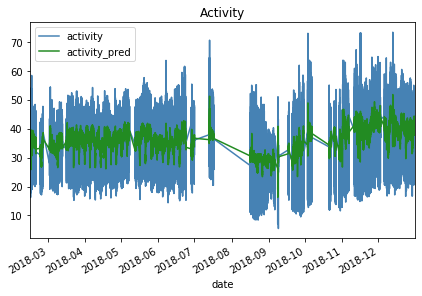

In [11]:
y_train_pred, y_val_pred, y_test_pred = denormalize_by_train(y_train_pred_n, y_val_pred_n, y_test_pred_n, train, TARGET)
y_train_pred_p = pd.Series(y_train_pred.flatten(), index=train.index, name=TARGET+"_pred").sort_index()

train["activity"].plot(c="steelblue")
y_train_pred_p.plot(c="forestgreen")
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)